In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)



# Time to First Treatment

In [4]:

# Time to first treatment
if nu.pickle_exists('time_to_treatment_df'):
    time_to_treatment_df = nu.load_object('time_to_treatment_df')
else:
    
    # Initialize an empty list to store rows of data
    rows_list = []
    
    # Loop through the grouped data (grouped by UUID and scene)
    for (session_uuid, time_group), df1 in nu.get_session_groupby(extra_column='time_group'):
        
        # Get the logger version
        logger_version = df1.logger_version.unique().item()
        
        # Create a boolean mask for 'INJURY_TREATED' action type
        action_mask_series = (df1.action_type == 'INJURY_TREATED')
        
        # Check if there are any rows with 'INJURY_TREATED' action type
        if df1[action_mask_series].shape[0]:
            # Initialize a dictionary to store row data
            row_dict = {}
            
            # Store logger_version, session_uuid, and time_group
            row_dict['logger_version'] = logger_version
            row_dict['session_uuid'] = session_uuid
            row_dict['time_group'] = time_group
            
            # Calculate and add the time to first treatment
            first_treatment = df1[action_mask_series].elapsed_time.min()
            row_dict['first_treatment'] = first_treatment
            
            # Create a mask for the row with the first treatment
            mask_series = action_mask_series & (df1.elapsed_time == first_treatment)
            
            # Get the patient ID of the first treatment and add it
            patient_id = df1[mask_series].patient_id.squeeze()
            row_dict['patient_id'] = patient_id
            
            # Create a mask for rows with the same patient_id
            mask_series = (df1.patient_id == patient_id)
            
            # Calculate the time to the first notice and add it
            first_notice = df1[mask_series].elapsed_time.min()
            row_dict['first_notice'] = first_notice
            
            # Calculate the time to treatment by subtracting first_notice from first_treatment
            time_to_treatment = first_treatment - first_notice
            row_dict['time_to_treatment'] = time_to_treatment
            
            # Append the row dictionary to the list of rows
            rows_list.append(row_dict)
    
    # Create a DataFrame from the list of row dictionaries
    time_to_treatment_df = DataFrame(rows_list)
    nu.store_objects(time_to_treatment_df=time_to_treatment_df)

In [5]:

time_to_treatment_df.sort_values('time_to_treatment')

,logger_version,session_uuid,time_group,first_treatment,patient_id,first_notice,time_to_treatment
284,1.0,6e3a5d8b-12c4-4afd-9a2e-619eb5b72b23,1,30718,Gloria_2 Root,20571,10147
266,1.3,67ed9702-0908-454a-8069-7ca4a6f2bee9,2,222429,Mike_5 Root,212151,10278
281,1.0,6d21f440-1c45-4c53-ad64-4edb92a94e25,1,28351,Mike_2 Root,17132,11219
483,1.0,c090fff8-5f81-40c5-b313-5fb7ce42ab9f,1,33510,Gloria_2 Root,22047,11463
198,1.0,48c426ae-e88c-49bd-8010-37dc7b042c95,1,49908,Gloria_2 Root,38444,11464
...,...,...,...,...,...,...,...
430,1.3,a7804ee3-6a1c-4462-957a-17976a540483,3,812501,Gary_3 Root,557468,255033
318,1.3,75b3227f-2f3c-4fe0-b9b8-9e0fe3baa210,2,609133,Lily_4 Root,352038,257095
264,1.3,677d1c18-f292-4bcb-924d-52f5e762533f,2,716069,Mike_7 Root,441771,274298
347,1.3,84282ed0-0e63-44e0-8b39-5156e3c868d0,2,749317,Gary_3 Root,446817,302500


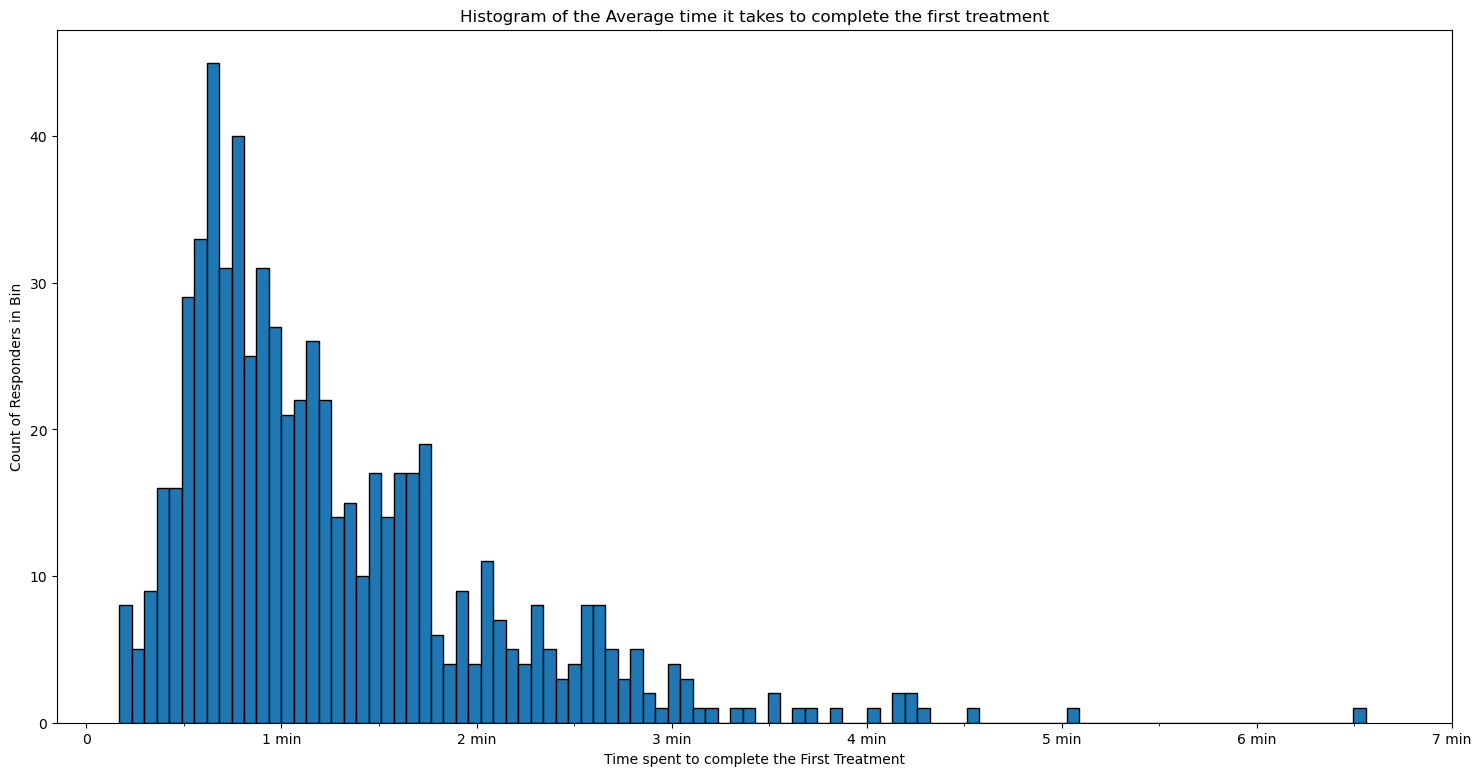

In [6]:

# Histogram of the time it takes to complete first treatment
xlabel = 'Time spent to complete the First Treatment'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: nu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the Average time it takes to complete the first treatment'
ylabel = 'Count of Responders in Bin'
ax = nu.plot_histogram(time_to_treatment_df, 'time_to_treatment', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True)

In [7]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'time_to_treatment'
]
df = time_to_treatment_df[columns_list]
nu.show_time_statistics(columns_list, df)

,mean,mode,median,SD,min,25%,50%,75%,max
time_to_treatment,1:15,35,1:01,48,10,41,1:01,1:37,6:33


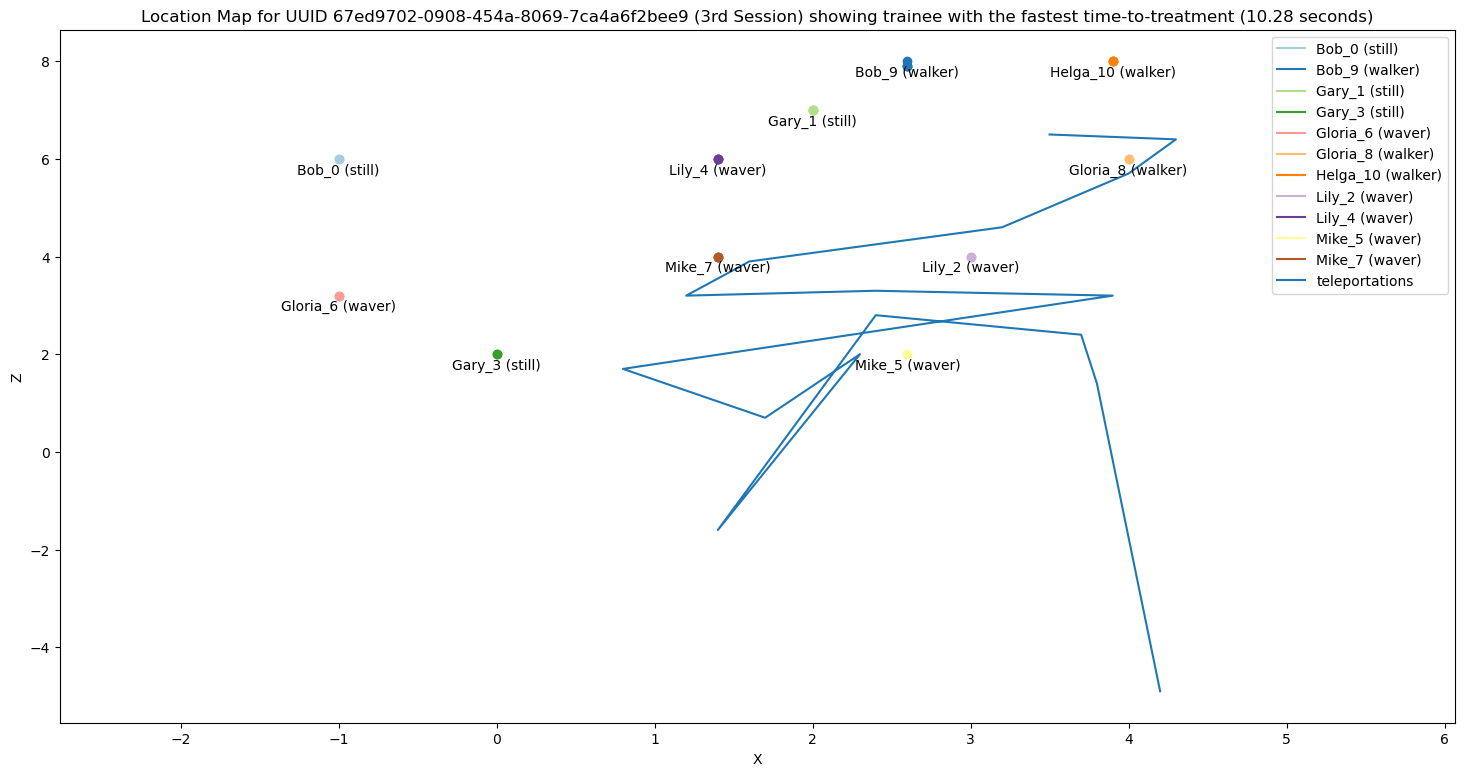

In [6]:

# Get scene with the fastest time to treatment, v1.3
mask_series = (time_to_treatment_df.logger_version == 1.3)
nu.visualize_extreme_player_movement(
    time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=True, humanize_type='precisedelta',
    title_str='fastest time-to-treatment', frvrs_logs_df=None, verbose=False
)

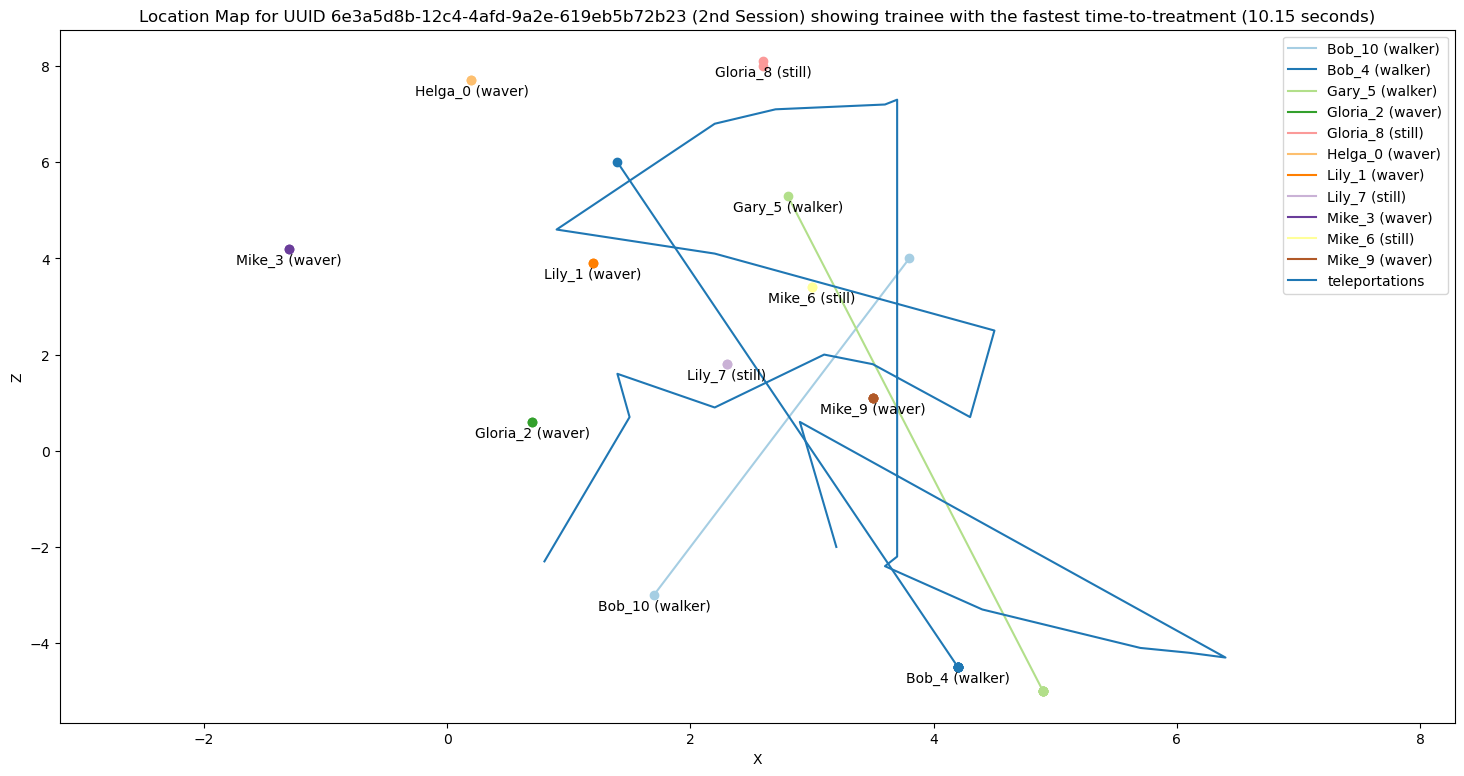

In [7]:

# Get scene with the fastest time to treatment, v1.0
mask_series = (time_to_treatment_df.logger_version == 1.0)
nu.visualize_extreme_player_movement(
    time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=True, humanize_type='precisedelta',
    title_str='fastest time-to-treatment', frvrs_logs_df=None, verbose=False
)

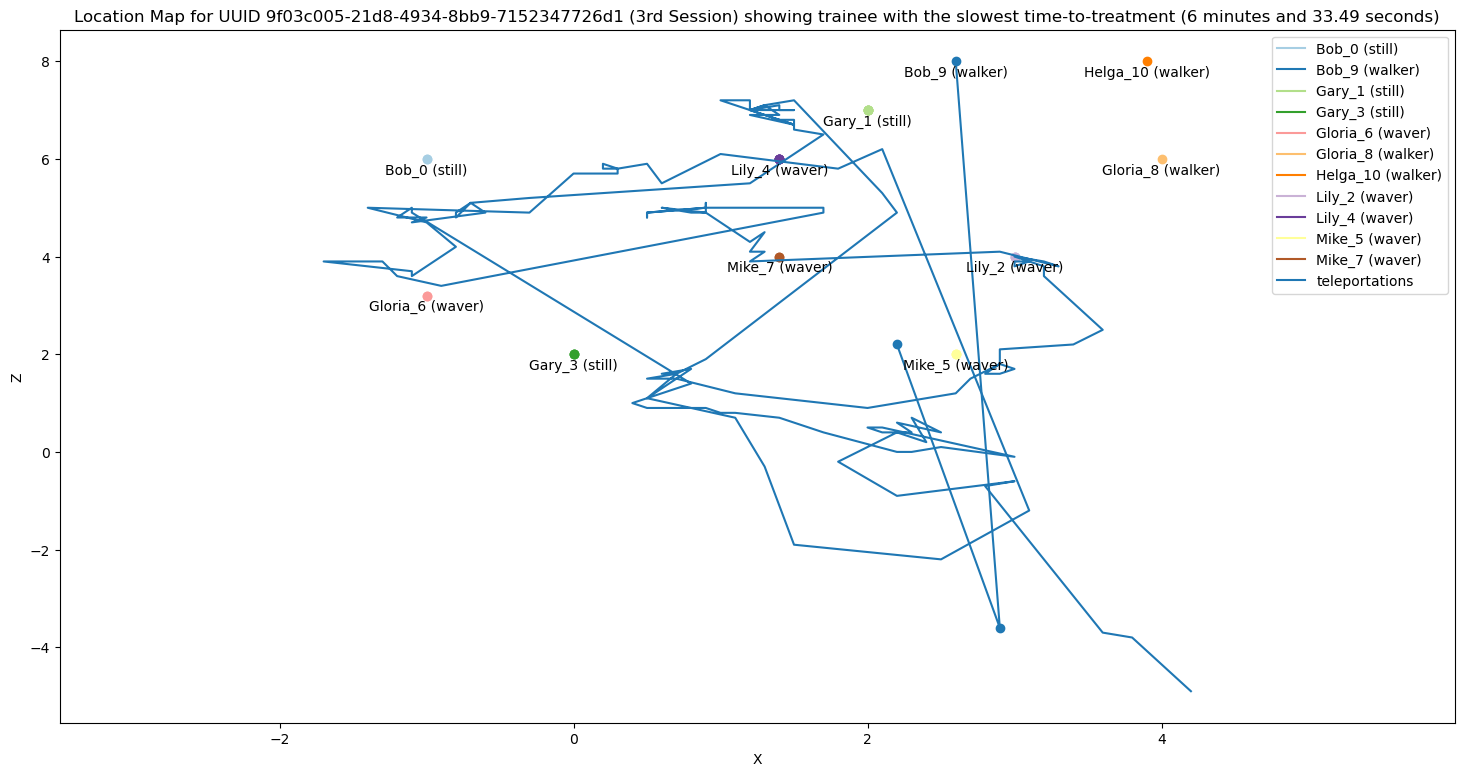

In [8]:

# Get scene with the slowest time to treatment, v1.3
mask_series = (time_to_treatment_df.logger_version == 1.3)
nu.visualize_extreme_player_movement(
    time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=False, humanize_type='precisedelta',
    title_str='slowest time-to-treatment', frvrs_logs_df=None, verbose=False
)

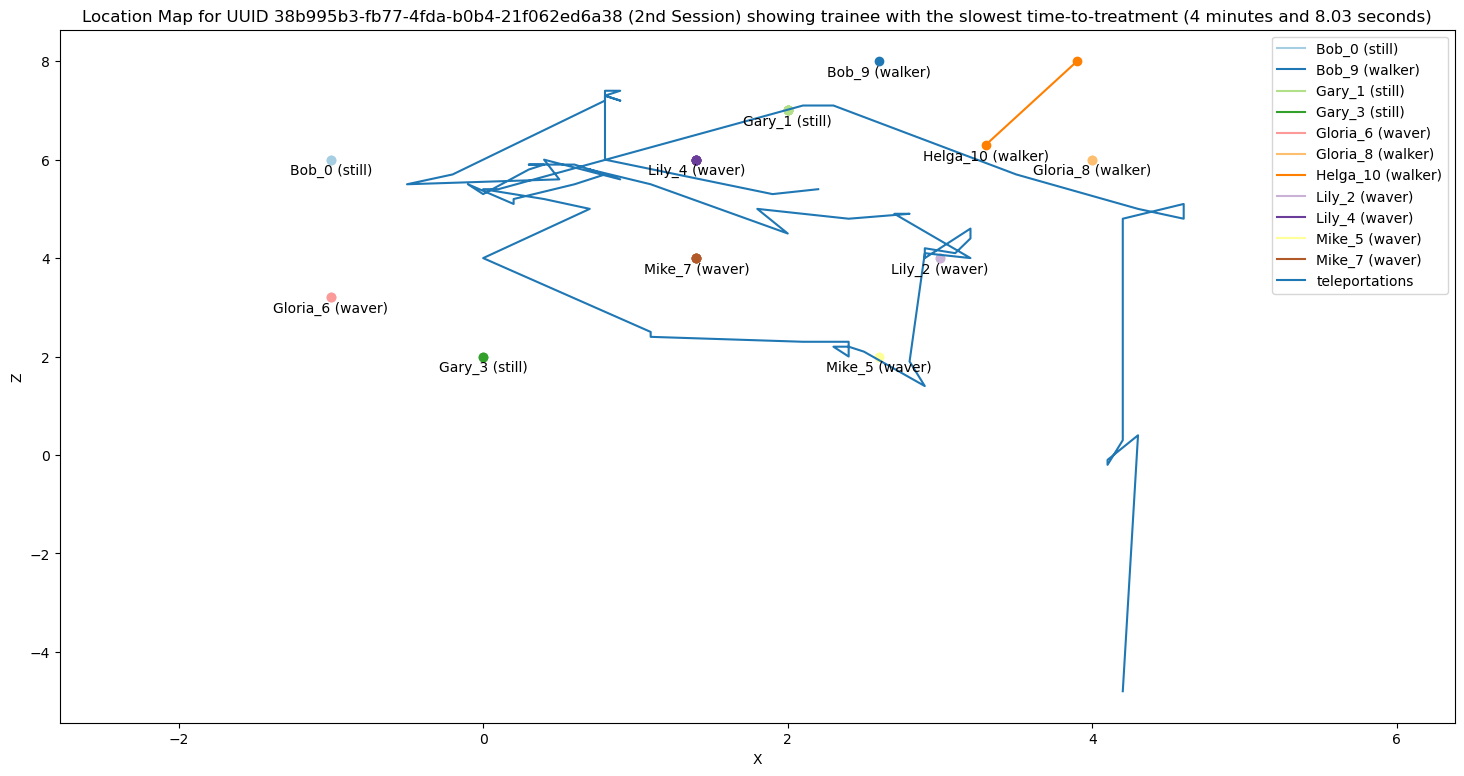

In [9]:

# Get scene with the slowest time to treatment, v1.0
mask_series = (time_to_treatment_df.logger_version == 1.0)
nu.visualize_extreme_player_movement(
    time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=False, humanize_type='precisedelta',
    title_str='slowest time-to-treatment', frvrs_logs_df=None, verbose=False
)